In [11]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
from datasets import MPSDataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import util
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

#%matplotlib widget

In [2]:
def inference(model, data_loader):
    features = []
    labels = []

    for patch, date in tqdm(data_loader):
        feats = model(patch)
        features.append(feats.detach().cpu().numpy())
        labels.append(date.detach().cpu().numpy())

    return np.concatenate(features), np.concatenate(labels)

In [3]:
resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.fc = nn.Identity()
resnet.eval()

DATA_PATH = "../MPS/Download"

dataset = MPSDataset(DATA_PATH)

loader = DataLoader(dataset, batch_size=8, num_workers=16)

feats, labels = inference(resnet, loader)

100%|██████████| 409/409 [03:51<00:00,  1.77it/s]


In [5]:
train_feat, test_feat, train_labels, test_labels = train_test_split(feats, labels, test_size=0.3)

In [13]:
def mae(true, pred):
    pred = np.round(pred)
    n = np.max(pred.shape)
    return np.sum(np.abs(true - pred)) / n

def mse(true, pred):
    pred = np.round(pred)
    n = np.max(pred.shape)
    return np.sum(np.square(true - pred)) / n

def cs(true, pred):
    alphas = [0, 25]
    pred = np.round(pred)
    n = np.max(pred.shape)
    diff = np.abs(true - pred)
    return [(np.count_nonzero(diff <= a) / n) * 100 for a in alphas]

In [17]:
print(train_feat.shape)
svm = SVR(kernel="rbf")
svm.fit(train_feat, train_labels)

(2286, 2048)


SVR()

In [18]:
predict = svm.predict(test_feat)
print(cs(test_labels, predict))
print(mae(test_labels, predict))
print(mse(test_labels, predict))

[0.8154943934760449, 32.92558613659531]
47.505606523955144
3570.826707441386


In [ ]:
data_np = np.concatenate(data)
labels_np = np.concatenate(labels)
print(data_np.shape)
m = PCA(n_components=2048)
#reduction = StandardScaler().fit_transform(data_np)
reduction = m.fit_transform(data_np)

(3267, 2048)


In [ ]:
new_labels = []
for x in labels:
    new_labels.append(x.detach().cpu().numpy())
new_labels = np.concatenate(new_labels)
new_labels

array([1300., 1300., 1300., ..., 1550., 1550., 1550.], dtype=float32)

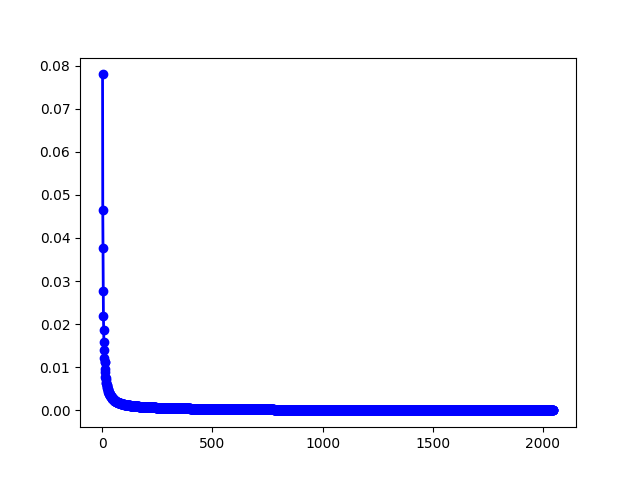

In [ ]:
PC_values = np.arange(m.n_components_) + 1
plt.plot(PC_values, m.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


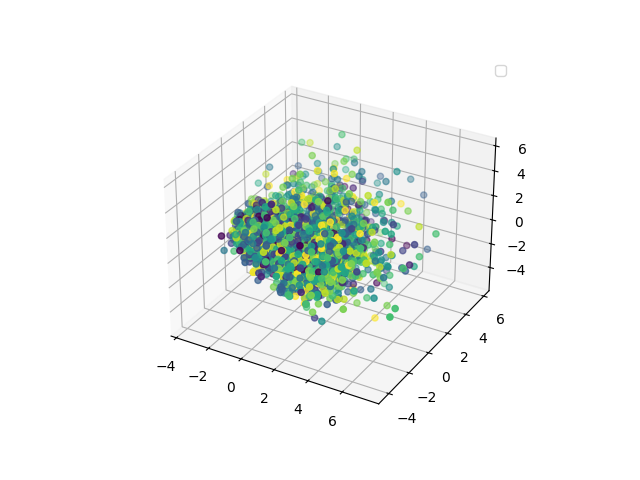

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(reduction[:,0], reduction[:,1],reduction[:,2], c=labels_np)
plt.legend()
plt.show()
#plt.axes(projection='2d')
# plt.clf()
# sns.scatterplot(x=reduction[:,0], y=reduction[:,1], hue=labels_np)
# plt.show()
